# New York City Airbnb Price Prediction using a MultiLayer Perceptron **(MLP)**

Business often needs to take predictions to another level. They are not longer using the classic approaches and need other types of models to gain more perspective. This is an example of a MultiLayer Perceptron, or well known as a feed forward deep network. 

The objective of this project is to try to predict the Airbnb listed property price in the New York City area.

<img src="new-york-city-airbnb-open-data/New_York_City_.png"/>

## Steps of the project

1. Loading libraries and frameworks
2. Exploratory Data Analysis and Feature Engineering
    - Dropping columns/rows
    - Missing data
    - Distplots
    - Scaling / Normalization
    - One Hot Encoding
4. Train, validation, and test splits
5. MLP
6. Results

## The Airbnb dataset

This data set contains the following structure and information. You can find it available in https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/downloads/new-york-city-airbnb-open-data.zip/3

**Dimensions** (48895, 16)

Includes the following features:

| Variable	                     | Definition	                                        |
|--------------------------------|------------------------------------------------------|
| Id                             | Listing ID                                           |
| Name                           | Name of the listing                                  |
| Host Id	                     | Host ID                                              | 
| Host Name                      | Name of the host                                     |
| Neighbourhood Group            | Location                                             |
| Neighbourhood                  | Area	                                                |
| Latitude                       | Latitude coordinate                                  |    
| Longitude                      | Longitude coordinate                                 |          
| Room Type                      | Listing space type	                                |
| Price                          | Listing price in US Dollars                          |
| Minimum Nights                 | Minimum nights for the stay                          |
| Number of Reviews              | Number of reviews                                    |
| Last Review                    | Date of last review                                  |     
| Reviews per Month              | Number of reviews per month                          |
| Calculated Host Listings Count | Amount of listing per host                           |
| Availability 365               | Number of days when listing is available for booking | 

The variable we want to predict is **price** which is a numeric feature in USD

## Libraries

The following libraries are used in this project:

| Library        | Description                                        |
|----------------|----------------------------------------------------|
| numpy          | Data wrangling, operations and data structures     |
| pandas         | For data structures and data analysis tools        |
| scikit-learn   | For label encoding and set splitting               |
| matplotlib     | Data visualization                                 |
| seaborn        | Data visualization                                 |
| tensorflow     | Machine learning framework                         |
| keras          | As the main deep learning wrapper                  |

In [226]:
#For data processing, operations, structures, and encoding
import numpy as np
import pandas as pd
import time
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.interpolation import shift

#For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#For deep learning
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import optimizers

## Importing data

In [237]:
df_raw = pd.read_csv('new-york-city-airbnb-open-data/AB_NYC_2019.csv')

In [238]:
df_raw.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

## Exploratory Data Analysis (EDA) and Feature Engineering

Dropping all columns that will not be used in the analysis

In [279]:
df = df_raw.drop(['id', 'name', 'host_id', 'host_name', 'last_review', 'latitude', 'longitude'], axis = 1)

We can now start understanding the data

In [280]:
num_cols = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 
            'calculated_host_listings_count', 'availability_365']

In [281]:
cat_cols = ['neighbourhood_group', 'neighbourhood', 'room_type']

In [282]:
stats = []
for i in num_cols:
    stats = np.hstack((stats,[{"Variable": i,
                               "Mean": np.round(np.nanmean(df[i]),2),
                               "Max": np.round(np.nanmax(df[i]),2),
                               "Min": np.round(np.nanmin(df[i]),2),
                               "Range": np.round(np.nanmax(df[i]) - np.nanmin(df[i]),2),
                               "Std": np.round(np.nanstd(df[i]),2)}]))
stats

array([{'Variable': 'minimum_nights', 'Mean': 7.03, 'Max': 1250, 'Min': 1, 'Range': 1249, 'Std': 20.51},
       {'Variable': 'number_of_reviews', 'Mean': 23.27, 'Max': 629, 'Min': 0, 'Range': 629, 'Std': 44.55},
       {'Variable': 'reviews_per_month', 'Mean': 1.37, 'Max': 58.5, 'Min': 0.01, 'Range': 58.49, 'Std': 1.68},
       {'Variable': 'calculated_host_listings_count', 'Mean': 7.14, 'Max': 327, 'Min': 1, 'Range': 326, 'Std': 32.95},
       {'Variable': 'availability_365', 'Mean': 112.78, 'Max': 365, 'Min': 0, 'Range': 365, 'Std': 131.62}],
      dtype=object)

### Checking for missing values

In [283]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
missing_value_df

column_name  \
neighbourhood_group                        neighbourhood_group   
neighbourhood                                    neighbourhood   
room_type                                            room_type   
price                                                    price   
minimum_nights                                  minimum_nights   
number_of_reviews                            number_of_reviews   
reviews_per_month                            reviews_per_month   
calculated_host_listings_count  calculated_host_listings_count   
availability_365                              availability_365   

                                percent_missing  
neighbourhood_group                    0.000000  
neighbourhood                          0.000000  
room_type                              0.000000  
price                                  0.000000  
minimum_nights                         0.000000  
number_of_reviews                      0.000000  
reviews_per_month                     20.558339  
calculated_host_listings_count         0.000000  
availability_365                       0.000000

We're going to replace all missing values from last_review and reviews_per_month to zero.

In [284]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

### Distplots

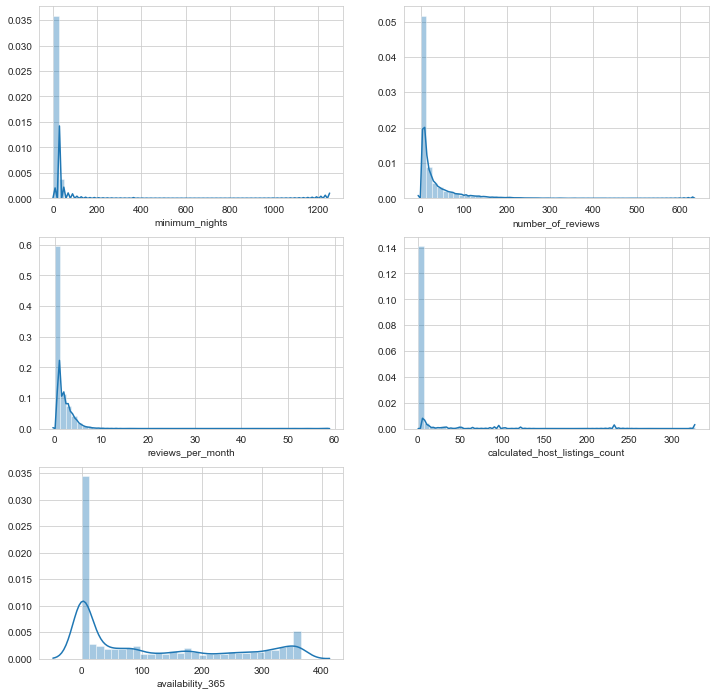

In [285]:
plt.figure(figsize=(12,12))
sns.set_style("whitegrid")
for col in range(len(num_cols)):
    plt.subplot(3,2,col+1)
    sns.distplot(df[num_cols[col]])

### Correlations

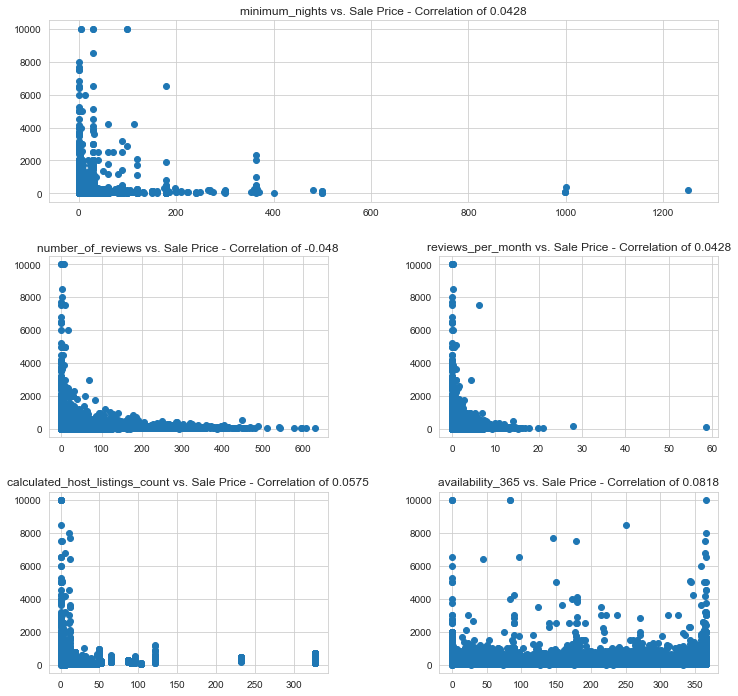

In [286]:
plt.figure(figsize=(12,12))
grid = plt.GridSpec(3, 2, wspace=0.4, hspace=0.3)
plt.subplot(grid[0, 0:])
plt.scatter(x=df[num_cols[0]], y=df['price'])
plt.title(num_cols[0]+' vs. Sale Price - Correlation of ' + 
          str(np.round(np.corrcoef(x=df[num_cols[0]], y=df['price'])[0,1],4)))
plt.subplot(grid[1, 0])
plt.scatter(x=df[num_cols[1]], y=df['price'])
plt.title(num_cols[1]+' vs. Sale Price - Correlation of ' + 
          str(np.round(np.corrcoef(x=df[num_cols[1]], y=df['price'])[0,1],4)))
plt.subplot(grid[1, 1])
plt.scatter(x=df[num_cols[2]], y=df['price'])
plt.title(num_cols[2]+' vs. Sale Price - Correlation of ' + 
          str(np.round(np.corrcoef(x=df[num_cols[0]], y=df['price'])[0,1],4)))
plt.subplot(grid[2, 0])
plt.scatter(x=df[num_cols[3]], y=df['price'])
plt.title(num_cols[3]+' vs. Sale Price - Correlation of ' + 
          str(np.round(np.corrcoef(x=df[num_cols[3]], y=df['price'])[0,1],4)))
plt.subplot(grid[2, 1])
plt.scatter(x=df[num_cols[4]], y=df['price'])
plt.title(num_cols[4]+' vs. Sale Price - Correlation of ' + 
          str(np.round(np.corrcoef(x=df[num_cols[4]], y=df['price'])[0,1],4)))
plt.show()

In [287]:
df.shape

(48895, 9)

In [288]:
df.describe()

price  minimum_nights  number_of_reviews  reviews_per_month  \
count  48895.000000    48895.000000       48895.000000       48895.000000   
mean     152.720687        7.029962          23.274466           1.090910   
std      240.154170       20.510550          44.550582           1.597283   
min        0.000000        1.000000           0.000000           0.000000   
25%       69.000000        1.000000           1.000000           0.040000   
50%      106.000000        3.000000           5.000000           0.370000   
75%      175.000000        5.000000          24.000000           1.580000   
max    10000.000000     1250.000000         629.000000          58.500000   

       calculated_host_listings_count  availability_365  
count                    48895.000000      48895.000000  
mean                         7.143982        112.781327  
std                         32.952519        131.622289  
min                          1.000000          0.000000  
25%                          1.000000          0.000000  
50%                          1.000000         45.000000  
75%                          2.000000        227.000000  
max                        327.000000        365.000000

## Scaling

In [289]:
scaler = MinMaxScaler()

X = df.drop('price', axis = 1)
y = df['price']

In [290]:
for col in num_cols:
    X[col] = scaler.fit_transform(df[[col]])

In [291]:
X.head()

neighbourhood_group neighbourhood        room_type  minimum_nights  \
0            Brooklyn    Kensington     Private room        0.000000   
1           Manhattan       Midtown  Entire home/apt        0.000000   
2           Manhattan        Harlem     Private room        0.001601   
3            Brooklyn  Clinton Hill  Entire home/apt        0.000000   
4           Manhattan   East Harlem  Entire home/apt        0.007206   

   number_of_reviews  reviews_per_month  calculated_host_listings_count  \
0           0.014308           0.003590                        0.015337   
1           0.071542           0.006496                        0.003067   
2           0.000000           0.000000                        0.000000   
3           0.429253           0.079316                        0.000000   
4           0.014308           0.001709                        0.000000   

   availability_365  
0          1.000000  
1          0.972603  
2          1.000000  
3          0.531507  
4          0.000000

## One Hot Encoding

In [292]:
X = pd.get_dummies(data = X, columns = cat_cols)

In [293]:
X.head()

minimum_nights  number_of_reviews  reviews_per_month  \
0        0.000000           0.014308           0.003590   
1        0.000000           0.071542           0.006496   
2        0.001601           0.000000           0.000000   
3        0.000000           0.429253           0.079316   
4        0.007206           0.014308           0.001709   

   calculated_host_listings_count  availability_365  \
0                        0.015337          1.000000   
1                        0.003067          0.972603   
2                        0.000000          1.000000   
3                        0.000000          0.531507   
4                        0.000000          0.000000   

   neighbourhood_group_Bronx  neighbourhood_group_Brooklyn  \
0                          0                             1   
1                          0                             0   
2                          0                             0   
3                          0                             1   
4                          0                             0   

   neighbourhood_group_Manhattan  neighbourhood_group_Queens  \
0                              0                           0   
1                              1                           0   
2                              1                           0   
3                              0                           0   
4                              1                           0   

   neighbourhood_group_Staten Island  ...  neighbourhood_Williamsburg  \
0                                  0  ...                           0   
1                                  0  ...                           0   
2                                  0  ...                           0   
3                                  0  ...                           0   
4                                  0  ...                           0   

   neighbourhood_Willowbrook  neighbourhood_Windsor Terrace  \
0                          0                              0   
1                          0                              0   
2                          0                              0   
3                          0                              0   
4                          0                              0   

   neighbourhood_Woodhaven  neighbourhood_Woodlawn  neighbourhood_Woodrow  \
0                        0                       0                      0   
1                        0                       0                      0   
2                        0                       0                      0   
3                        0                       0                      0   
4                        0                       0                      0   

   neighbourhood_Woodside  room_type_Entire home/apt  room_type_Private room  \
0                       0                          0                       1   
1                       0                          1                       0   
2                       0                          0                       1   
3                       0                          1                       0   
4                       0                          1                       0   

   room_type_Shared room  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

[5 rows x 234 columns]

In [294]:
print(X.shape)
print(y.shape)

(48895, 234)
(48895,)


In [295]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 100)

### Creating Log

In [324]:
log = pd.DataFrame(columns = ['Experiment', 'Description', 'Framework', 'Configuration', 'Loss', 'Error', 'Val Error'])

## MultiLayer Perceptron Model (Product Approach)

In [325]:
def mlperceptron(epochs, lr, batch_size, patience, x_train, y_train, x_val, y_val, architecture, last_activation, verbose, exp_name):
    
    global log
    global prod
    
    if exp_name in log['Experiment'].unique():
        print('The experiment name is already in use. Please change to a name that is not in the following list: '
              + str(log['Experiment'].unique()))
        return(0,0)
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=patience),
                 ModelCheckpoint('checkpoints/weights_checkpoints.h5', save_best_only=True, save_weights_only=False)]
    
    #Creating the sequence for the model
    model = Sequential()
    i=0
    if last_activation == True:
        for l in architecture['layers']:
            model.add(Dense(l, input_dim = x_train.shape[1], activation = architecture['activations'][i]))
            model.add(Dropout(architecture['dropout'][i]))
            i+=1
    elif last_activation == False:
        for l in architecture['layers']:
            model.add(Dense(l, input_dim = x_train.shape[1], activation = architecture['activations'][i]))
            model.add(Dropout(architecture['dropout'][i]))
            i+=1
        model.add(Dense(1))
        
    #To select the optimizer 
    if architecture['optimizer'] == 'sgd':
        opt = optimizers.SGD(lr = lr, decay = 1e-6, momentum = 0.9, nesterov = True)
    elif architecture['optimizer'] == 'adam':
        opt = optimizers.Adam(lr = lr, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
    
    model.compile(loss=architecture['loss'], optimizer=opt)
    
    model.summary()
    
    history = model.fit(
        x_train, 
        y_train, 
        epochs = epochs, 
        batch_size = batch_size,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        verbose = verbose
    )
    
    
    log_info = {
        'Experiment': exp_name, 
        'Description': 'MultiLayer Perceptron with ' + str(architecture['optimizer'] + ' optimizer'),
        'Framework': 'Keras',
        'Configuration': 'epochs = ' + str(epochs+1) + '; lr = ' + str(lr) + '; batch size = ' + str(batch_size), 
        'Loss': model.loss,
        'Error': model.history.history['loss'],
        'Val Error': model.history.history['val_loss']
    }
    log = log.append(log_info, ignore_index=True)
    
    return(model, history)

### Grid search: Batch Size

In [326]:
arq = {
    'layers': [10, 8, 4, 1],
    'activations': ['relu', 'relu', 'relu', 'relu'],
    'dropout':[0.5,0.5,0.5,0.5],
    'loss': 'mse',
    'optimizer': 'adam'
}
batch_size = [32,64,128]
i=0
for batch in batch_size:
    mlp, hist = mlperceptron(
        epochs = 100,
        lr = 0.001,
        batch_size = 128,
        patience = 20,
        x_train = X_train,
        y_train = y_train,
        x_val = X_val,
        y_val = y_val,
        architecture = arq,
        last_activation = False,
        verbose = 2,
        exp_name = "batch_exp_"+str(i)
    )
    i+=1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_122 (Dense)            (None, 13)                3055      
_________________________________________________________________
dropout_76 (Dropout)         (None, 13)                0         
_________________________________________________________________
dense_123 (Dense)            (None, 6)                 84        
_________________________________________________________________
dropout_77 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_124 (Dense)            (None, 1)                 7         
_________________________________________________________________
dropout_78 (Dropout)         (None, 1)                 0         
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 2         
Total para

Train on 39116 samples, validate on 4890 samples
Epoch 1/100
 - 6s - loss: 80411.0800 - val_loss: 77855.0151
Epoch 2/100
 - 1s - loss: 80309.0467 - val_loss: 77764.6683
Epoch 3/100
 - 1s - loss: 80216.7068 - val_loss: 77674.2185
Epoch 4/100
 - 2s - loss: 80124.6109 - val_loss: 77584.0256
Epoch 5/100
 - 2s - loss: 80032.6933 - val_loss: 77493.8675
Epoch 6/100
 - 2s - loss: 79941.0444 - val_loss: 77404.1987
Epoch 7/100
 - 2s - loss: 79849.7416 - val_loss: 77314.7435
Epoch 8/100
 - 2s - loss: 79758.6171 - val_loss: 77225.5576
Epoch 9/100
 - 1s - loss: 79667.7607 - val_loss: 77136.5361
Epoch 10/100
 - 1s - loss: 79577.1523 - val_loss: 77047.7847
Epoch 11/100
 - 1s - loss: 79486.7764 - val_loss: 76959.2691
Epoch 12/100
 - 2s - loss: 79396.5966 - val_loss: 76870.8809
Epoch 13/100
 - 2s - loss: 79306.6132 - val_loss: 76782.7623
Epoch 14/100
 - 2s - loss: 79216.7838 - val_loss: 76694.8385
Epoch 15/100
 - 1s - loss: 79127.1539 - val_loss: 76607.0913
Epoch 16/100
 - 2s - loss: 79037.8087 - val_l

Epoch 14/100
 - 1s - loss: 79215.2234 - val_loss: 76693.2508
Epoch 15/100
 - 1s - loss: 79125.5917 - val_loss: 76605.3397
Epoch 16/100
 - 1s - loss: 79036.1371 - val_loss: 76517.7856
Epoch 17/100
 - 1s - loss: 78946.9469 - val_loss: 76430.3583
Epoch 18/100
 - 1s - loss: 78857.9618 - val_loss: 76343.2923
Epoch 19/100
 - 1s - loss: 78769.0586 - val_loss: 76256.2136
Epoch 20/100
 - 1s - loss: 78680.2826 - val_loss: 76169.2614
Epoch 21/100
 - 1s - loss: 78591.7007 - val_loss: 76082.4059
Epoch 22/100
 - 1s - loss: 78503.3201 - val_loss: 75995.8775
Epoch 23/100
 - 1s - loss: 78415.1566 - val_loss: 75909.6734
Epoch 24/100
 - 1s - loss: 78327.1606 - val_loss: 75823.4773
Epoch 25/100
 - 1s - loss: 78239.3662 - val_loss: 75737.5117
Epoch 26/100
 - 1s - loss: 78151.8101 - val_loss: 75651.7712
Epoch 27/100
 - 1s - loss: 78064.4236 - val_loss: 75566.2561
Epoch 28/100
 - 1s - loss: 77977.2791 - val_loss: 75480.9449
Epoch 29/100
 - 1s - loss: 77890.3328 - val_loss: 75395.7765
Epoch 30/100
 - 1s - los

In [328]:
log

Experiment                                Description Framework  \
0  batch_exp_0  MultiLayer Perceptron with adam optimizer     Keras   
1  batch_exp_1  MultiLayer Perceptron with adam optimizer     Keras   
2  batch_exp_2  MultiLayer Perceptron with adam optimizer     Keras   

                                Configuration Loss  \
0  epochs = 101; lr = 0.001; batch size = 128  mse   
1  epochs = 101; lr = 0.001; batch size = 128  mse   
2  epochs = 101; lr = 0.001; batch size = 128  mse   

                                               Error  \
0  [80399.91347170915, 80306.84242541416, 80214.5...   
1  [80411.08003817972, 80309.04669804237, 80216.7...   
2  [80399.89354420186, 80307.06704737192, 80214.8...   

                                           Val Error  
0  [77853.37312595859, 77762.50540005113, 77672.1...  
1  [77855.01506103016, 77764.66826751022, 77674.2...  
2  [77853.34480125256, 77762.7905259458, 77672.43...

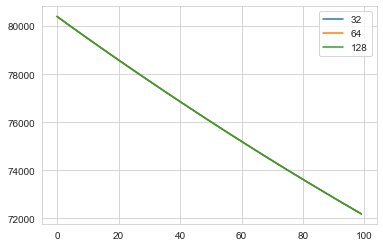

In [331]:
plt.plot(log[log['Experiment']=='batch_exp_0']['Error'].iloc[0], label = '32')
plt.plot(log[log['Experiment']=='batch_exp_1']['Error'].iloc[0], label = '64')
plt.plot(log[log['Experiment']=='batch_exp_2']['Error'].iloc[0], label = '128')
plt.legend()

The best model comes from a batch size of 64.

In [ ]:
plt.plot(log[log['Experiment']=='batch_exp_1']['Error'].iloc[0], label = '64 - Train Loss')
plt.plot(log[log['Experiment']=='batch_exp_1']['Error'].iloc[0], label = '64 - Train Loss')

### Grid search: Dropout

In [ ]:
dropout = [0.2, 0.3, 0.4, 0.5]
i=0
for batch in batch_size:
    mlp, hist = mlperceptron(
        epochs = 100,
        lr = 0.001,
        batch_size = 128,
        patience = 20,
        x_train = X_train,
        y_train = y_train,
        x_val = X_val,
        y_val = y_val,
        architecture = arq,
        last_activation = True,
        verbose = 2,
        exp_name = "batch_exp_"+str(i)
    )
    i+=1

In [322]:
X_test = X_test.drop('pred', axis = 1)
X_test['pred'] = mlp.predict(X_test, batch_size = 64)

In [323]:
pd.concat([X_test, y_test], axis = 1)

minimum_nights  number_of_reviews  reviews_per_month  \
10897        0.003203           0.004769           0.002735   
10313        0.000000           0.001590           0.000342   
46722        0.023219           0.000000           0.000000   
22554        0.001601           0.082671           0.033333   
754          0.291433           0.030207           0.003590   
31932        0.000000           0.006359           0.004957   
46143        0.023219           0.000000           0.000000   
12792        0.000801           0.001590           0.000513   
23597        0.001601           0.033386           0.014701   
1205         0.000801           0.213037           0.026667   
33255        0.003203           0.004769           0.004274   
10554        0.000801           0.001590           0.000342   
30720        0.023219           0.009539           0.008547   
32100        0.003203           0.023847           0.018974   
13527        0.001601           0.077901           0.021880   
16832        0.023219           0.000000           0.000000   
16338        0.000000           0.000000           0.000000   
3838         0.004804           0.000000           0.000000   
405          0.000801           0.023847           0.002564   
15717        0.000000           0.004769           0.001368   
5683         0.000000           0.321145           0.063932   
13747        0.000000           0.004769           0.001538   
10396        0.002402           0.034976           0.008034   
25262        0.003203           0.006359           0.002906   
16935        0.002402           0.071542           0.021709   
7288         0.000000           0.001590           0.000342   
17846        0.000000           0.001590           0.000855   
9954         0.004804           0.014308           0.003248   
32873        0.008807           0.000000           0.000000   
23733        0.000801           0.000000           0.000000   
...               ...                ...                ...   
31455        0.001601           0.023847           0.017265   
33301        0.002402           0.004769           0.004103   
20005        0.002402           0.001590           0.002735   
11372        0.000000           0.003180           0.000684   
23183        0.001601           0.025437           0.011966   
25121        0.000801           0.112878           0.051282   
48563        0.023219           0.000000           0.000000   
18226        0.002402           0.220986           0.068034   
26531        0.001601           0.063593           0.031624   
38792        0.023219           0.000000           0.000000   
27870        0.000000           0.036566           0.023248   
30823        0.010408           0.004769           0.004103   
22943        0.000801           0.171701           0.071453   
44415        0.000000           0.015898           0.076581   
37690        0.003203           0.000000           0.000000   
994          0.002402           0.030207           0.003761   
35718        0.000000           0.052464           0.057094   
28775        0.000801           0.022258           0.038803   
27183        0.000801           0.058824           0.030769   
13409        0.000000           0.001590           0.000342   
1156         0.001601           0.038156           0.005128   
26085        0.000801           0.011129           0.005470   
17151        0.000801           0.041335           0.012137   
7201         0.001601           0.000000           0.000000   
18558        0.000801           0.001590           0.000513   
35054        0.000801           0.036566           0.036239   
23795        0.000000           0.238474           0.102393   
3040         0.001601           0.015898           0.002564   
39081        0.003203           0.014308           0.021709   
10616        0.000000           0.030207           0.007009   

       calculated_host_listings_count  availability_365  \
10897                        0.000000    